# Variational Autoencoder

### create and train the variational autoencoder

In [0]:
hiddendim = 8
latentdim = 6

In [0]:
# build encoder (first step)
inputs = Input(shape=(10, ), name='encoder_input')
x = Dense(hiddendim, activation='relu')(inputs)
z_mean = Dense(latentdim, name='z_mean')(x)
z_sd = Dense(latentdim, name='z_sd')(x)

In [0]:
# reparametrization trick
def sampling(args):
    z_mean, z_sd = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
    return z_mean + K.square(z_sd) * epsilon

In [0]:
# layer object z
z = Lambda(sampling, output_shape=(latentdim,), name='z')([z_mean, z_sd])

In [0]:
# build encoder (second step)
encoder = Model(inputs, [z_mean, z_sd, z], name='encoder')

In [0]:
# build decoder (first step)
latent_inputs = Input(shape=(latentdim,), name='z_sampling')
x = Dense(hiddendim, activation='relu')(latent_inputs)
outputs = Dense(10, activation='tanh')(x)

In [0]:
# build decoder (second step)
decoder = Model(latent_inputs, outputs, name='decoder')

In [0]:
# build VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_model')

In [0]:
#define loss function
reconstruction_loss = mse(inputs, outputs)
kl_loss = (K.square(z_mean) + K.square(z_sd) - K.log(K.square(z_sd)) - 1)/2
kl_loss = K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [0]:
vae.compile(optimizer='adam')

In [0]:
vae.fit(baddata, epochs=5, batch_size=6, validation_data=(baddata, None))

Train on 8357 samples, validate on 8357 samples
Epoch 1/5
8357/8357 [==============================] - 6s 763us/step - loss: 9.3424 - val_loss: 8.3752
Epoch 2/5
8357/8357 [==============================] - 6s 703us/step - loss: 8.0286 - val_loss: 7.7121
Epoch 3/5
8357/8357 [==============================] - 5s 563us/step - loss: 7.5298 - val_loss: 7.3149
Epoch 4/5
8357/8357 [==============================] - 6s 680us/step - loss: 7.0407 - val_loss: 6.8930
Epoch 5/5
8357/8357 [==============================] - 5s 608us/step - loss: 6.8307 - val_loss: 6.6799


### generate synthetic data of the minority class and add it to creditdata

In [0]:
mean = [0,0,0,0,0,0]
cov = [[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]

In [0]:
nd = 103555

In [0]:
syntheticdata = pd.DataFrame.from_records(decoder.predict(np.random.multivariate_normal(mean,cov,nd)))

In [0]:
syntheticdata.insert(loc=0, column='blub', value=[1]*nd)
syntheticdata = syntheticdata.values
syntheticdata = pd.DataFrame(syntheticdata)
syntheticdata = syntheticdata.rename(index=str, columns={0: "SeriousDlqin2yrs", 1: "RevolvingUtilizationOfUnsecuredLines", 2: "age", 3: "NumberOfTime30-59DaysPastDueNotWorse", 4: "DebtRatio", 5: "MonthlyIncome", 6: "NumberOfOpenCreditLinesAndLoans", 7: "NumberOfTimes90DaysLate", 8: "NumberRealEstateLoansOrLines", 9: "NumberOfTime60-89DaysPastDueNotWorse", 10: "NumberOfDependents"})
syntheticdata['SeriousDlqin2yrs'] = syntheticdata.SeriousDlqin2yrs.astype(int)

In [0]:
bigdata = pd.concat([creditdata, syntheticdata], ignore_index=True, sort=False)

In [0]:
print(bigdata.groupby('SeriousDlqin2yrs').size())

SeriousDlqin2yrs
0    111912
1    111912
dtype: int64


### train model with augmented dataset

In [0]:
feature_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
X = bigdata[feature_cols]
y = bigdata.SeriousDlqin2yrs

In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [0]:
model.fit(x = X_train2, y = y_train2,
          validation_data=[X_test, y_test],
          epochs = 4,
          batch_size=20)

Train on 134294 samples, validate on 48108 samples
Epoch 1/4
134294/134294 [==============================] - 22s 164us/step - loss: 0.3069 - acc: 0.9327 - val_loss: 0.3700 - val_acc: 0.9049
Epoch 2/4
134294/134294 [==============================] - 21s 160us/step - loss: 0.2894 - acc: 0.9359 - val_loss: 0.3666 - val_acc: 0.9043
Epoch 3/4
134294/134294 [==============================] - 28s 205us/step - loss: 0.2830 - acc: 0.9363 - val_loss: 0.3519 - val_acc: 0.9087
Epoch 4/4
134294/134294 [==============================] - 29s 218us/step - loss: 0.2782 - acc: 0.9365 - val_loss: 0.3539 - val_acc: 0.9074


In [0]:
nn_pred = model.predict(X_test)
print('AUC: ', metrics.roc_auc_score(y_test, nn_pred))

AUC:  0.8101516651859857


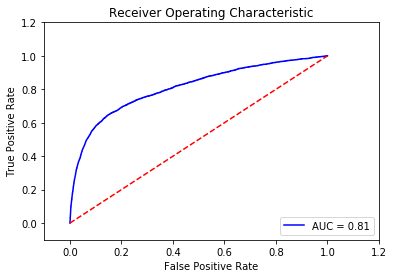

In [0]:
actual = y_test
predictions = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()